In [2]:
pip install chart_studio

     |████████████████████████████████| 71kB 2.3MB/s 


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import chart_studio
from collections import Counter
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
project_data = pd.read_csv('/content/drive/My Drive/6_Donors_choose_NB/train_data.csv')

In [6]:
project_data.head(5)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [7]:
teacher_prefixL=project_data['teacher_prefix'].values
teacher_prefixL=list(teacher_prefixL)
cleanedteacher_prefixL = [x for x in project_data['teacher_prefix'] if x != float('nan')] ## Cleaning the nan Values in the list -> https://stackoverflow.com/a/50297200/4433839
len(cleanedteacher_prefixL)

109248

In [8]:

project_data.dropna(subset=['teacher_prefix'], inplace=True)  ##https://stackoverflow.com/a/29314880/4433839
project_data.shape #(reduced 3 columns containing nan values)

(109245, 17)

Data Preprocessing step

In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [0]:
# this code removes " " and "-". ie Grades 3-5 -> grage3to5
#  remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
clean_grades=[]
for project_grade in project_data['project_grade_category'].values:
    project_grade=str(project_grade).lower().strip().replace(' ','').replace('-','to')
    
    clean_grades.append(project_grade.strip())

project_data['clean_project_grade_category']=clean_grades
project_data.drop(['project_grade_category'],axis=1,inplace=True)

my_counter = Counter()
for word in project_data['clean_project_grade_category'].values:
    my_counter.update(word.split())
    
grade_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))

In [0]:
# merging essays column : text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [13]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,clean_project_grade_category,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,gradesprekto2,My students are English learners that are work...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,grades6to8,Our students arrive to our school eager to lea...


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [16]:
# removing unwanted symbols , space etc from essay column therby making it more meaningful for our data model
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109245/109245 [00:58<00:00, 1861.99it/s]


In [0]:
## adding processed essay and removing unprocessed essay
project_data['preprocessed_essays'] = preprocessed_essays
project_data.drop(['essay'], axis=1, inplace=True)

In [18]:
preprocessed_essays[50000]

'students potential world need help acquiring adequate resources facilitate success students always excited energetic engaged music class soak every concept like sponge ask interesting questions never give would love see students able play instruments together compose music fully immersed every facet music e music class addition obvious musical benefits extra resources allow students activities make well rounded individuals overall not music classroom music classroom currently minimal number available resources small budget shared elementary music middle school choir middle school high school band able obtain materials elementary classroom make sure students musically interested literate secondary programs continue grow addition resources classroom k 5 students able challenge not understand concept able apply concept real physical way students able work together make actual music perform level comprehension increase opportunity solidify learned class learn perseverance determination pa

In [19]:
# similarly preprocessing the titles column
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109245/109245 [00:02<00:00, 43142.06it/s]


In [0]:
project_data['preprocessed_titles'] = preprocessed_titles

In [21]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories',
       'clean_project_grade_category', 'preprocessed_essays',
       'preprocessed_titles'],
      dtype='object')

Splitting data step

In [132]:
#dividing the whole dataset into the ratio of (train:test) = 80:20 
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(project_data,project_data['project_is_approved'],test_size=0.2,random_state=42,stratify=project_data[['project_is_approved']])
print("x_train: ",x_train.shape)
print("x_test : ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test : ",y_test.shape)

x_train:  (87396, 23)
x_test :  (21849, 23)
y_train:  (87396,)
y_test :  (21849,)


Vectorization Step

In [23]:
# using CountVectorizer to convert the features into one hot encoding 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_sub = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub.fit(x_train['clean_categories'].values)
x_train_categories_one_hot = vectorizer_sub.transform(x_train['clean_categories'].values)
x_test_categories_one_hot  = vectorizer_sub.transform(x_test['clean_categories'].values)

print(vectorizer_sub.get_feature_names())
print("Shape of matrix after one hot encoding: x_train: ",x_train_categories_one_hot.shape)
print("Shape of matrix after one hot encoding: x_test : ",x_test_categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encoding: x_train:  (87396, 9)
Shape of matrix after one hot encoding: x_test :  (21849, 9)


In [24]:
vectorizer_sub_sub = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub_sub.fit(x_train['clean_subcategories'].values)
x_train_sub_categories_one_hot = vectorizer_sub_sub.transform(x_train['clean_subcategories'].values)
x_test_sub_categories_one_hot  = vectorizer_sub_sub.transform(x_test['clean_subcategories'].values)

print(vectorizer_sub_sub.get_feature_names())
print("Shape of matrix after one hot encoding: x_train: ",x_train_sub_categories_one_hot.shape)
print("Shape of matrix after one hot encoding: x_test : ",x_test_sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encoding: x_train:  (87396, 30)
Shape of matrix after one hot encoding: x_test :  (21849, 30)


In [0]:
my_counter = Counter()
for state in project_data['school_state'].values:
    my_counter.update(state.split())
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [26]:
#https://stackoverflow.com/questions/8955448/save-load-scipy-sparse-csr-matrix-in-portable-data-format
from scipy import sparse 
statelist=list(project_data['school_state'].values)
vectorizer_state = CountVectorizer(vocabulary=set(statelist), lowercase=False, binary=True)
vectorizer_state.fit(x_train['school_state'])
x_train_school_state_one_hot = vectorizer_state.transform(x_train['school_state'].values)
x_test_school_state_one_hot  = vectorizer_state.transform(x_test['school_state'].values)

print(vectorizer_state.get_feature_names())
print("Shape of matrix after one hot encoding: x_train: ",x_train_school_state_one_hot.shape)
print("Shape of matrix after one hot encoding: x_test : ",x_test_school_state_one_hot.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of matrix after one hot encoding: x_train:  (87396, 51)
Shape of matrix after one hot encoding: x_test :  (21849, 51)


In [0]:
my_counter = Counter()
for teacher_prefix in project_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix).lower().replace('.','').strip()
    my_counter.update(teacher_prefix.split())

teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_prefix = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_prefix.fit(x_train['teacher_prefix'].values)
x_train_prefix_one_hot = vectorizer_prefix.transform(x_train['teacher_prefix'].values)
x_test_prefix_one_hot  = vectorizer_prefix.transform(x_test['teacher_prefix'].values)

print(vectorizer_prefix.get_feature_names())
print("Shape of matrix after one hot encoding: x_train: ",x_train_prefix_one_hot.shape)
print("Shape of matrix after one hot encoding: x_test : ",x_test_prefix_one_hot.shape)

['dr', 'teacher', 'mr', 'ms', 'mrs']
Shape of matrix after one hot encoding: x_train:  (87396, 5)
Shape of matrix after one hot encoding: x_test :  (21849, 5)


In [29]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_grade = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_grade.fit(x_train['clean_project_grade_category'].values)
x_train_grade_category_one_hot = vectorizer_grade.transform(x_train['clean_project_grade_category'].values)
x_test_grade_category_one_hot  = vectorizer_grade.transform(x_test['clean_project_grade_category'].values)

print(vectorizer_grade.get_feature_names())
print("Shape of matrix after one hot encoding: x_train : ",x_train_grade_category_one_hot.shape)
print("Shape of matrix after one hot encoding: x_test  : ",x_test_grade_category_one_hot.shape)


['grades9to12', 'grades6to8', 'grades3to5', 'gradesprekto2']
Shape of matrix after one hot encoding: x_train :  (87396, 4)
Shape of matrix after one hot encoding: x_test  :  (21849, 4)


In [30]:
x_train_grade_category_one_hot.toarray()

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
teacher_previous_proj_normalizer = Normalizer()
teacher_previous_proj_normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
x_train_teacher_previous_proj_normalized = teacher_previous_proj_normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,- 1)).reshape(-1,1)
x_test_teacher_previous_proj_normalized  = teacher_previous_proj_normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(1,- 1)).reshape(-1,1)

print("Shape of matrix after normalization: x_train:  ",x_train_prefix_one_hot.shape)
print("Shape of matrix after normalization: x_test :  ",x_test_prefix_one_hot.shape)


Shape of matrix after normalization: x_train:   (87396, 5)
Shape of matrix after normalization: x_test :   (21849, 5)


BOW part

In [42]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html (for converting into bigrams)
vectorizer_essay_bow = CountVectorizer(min_df=10,ngram_range=(2, 2))
vectorizer_essay_bow.fit(x_train['preprocessed_essays'])
x_train_essays_bow = vectorizer_essay_bow.transform(x_train['preprocessed_essays'])
x_test_essays_bow  = vectorizer_essay_bow.transform(x_test['preprocessed_essays'])

print("Shape of matrix after BOW -> Essays: x_train: ",x_train_essays_bow.shape)
print("Shape of matrix after BOW -> Essays: x_test : ",x_test_essays_bow.shape)

Shape of matrix after BOW -> Essays: x_train:  (87396, 147303)
Shape of matrix after BOW -> Essays: x_test :  (21849, 147303)


In [43]:
vectorizer_title_bow = CountVectorizer(min_df=10,ngram_range=(2, 2))
vectorizer_title_bow.fit(x_train['preprocessed_titles'])
x_train_titles_bow = vectorizer_title_bow.transform(x_train['preprocessed_titles'])
x_test_titles_bow  = vectorizer_title_bow.transform(x_test['preprocessed_titles'])

print("Shape of matrix after BOW -> Title: x_train: ",x_train_titles_bow.shape)
print("Shape of matrix after BOW -> Title: x_test : ",x_test_titles_bow.shape)

Shape of matrix after BOW -> Title: x_train:  (87396, 3323)
Shape of matrix after BOW -> Title: x_test :  (21849, 3323)


TF-IDF part

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_essay_tfidf = TfidfVectorizer(min_df=10,ngram_range=(2, 2))
vectorizer_essay_tfidf.fit(x_train['preprocessed_essays'])
x_train_essays_tfidf = vectorizer_essay_tfidf.transform(x_train['preprocessed_essays'])
x_test_essays_tfidf  = vectorizer_essay_tfidf.transform(x_test['preprocessed_essays'])

print("Shape of matrix after TF-IDF -> Essay: x_train: ",x_train_essays_tfidf.shape)
print("Shape of matrix after TF-IDF -> Essay: x_test : ",x_test_essays_tfidf.shape)

Shape of matrix after TF-IDF -> Essay: x_train:  (87396, 147303)
Shape of matrix after TF-IDF -> Essay: x_test :  (21849, 147303)


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_title_tfidf = TfidfVectorizer(min_df=10,ngram_range=(2, 2))
vectorizer_title_tfidf.fit(x_train['preprocessed_titles'])
x_train_titles_tfidf = vectorizer_title_tfidf.transform(x_train['preprocessed_titles'])
x_test_titles_tfidf  = vectorizer_title_tfidf.transform(x_test['preprocessed_titles'])

print("Shape of matrix after TF-IDF -> Title: x_train: ",x_train_titles_tfidf.shape)
print("Shape of matrix after TF-IDF -> Title: x_test : ",x_test_titles_tfidf.shape)

Shape of matrix after TF-IDF -> Title: x_train:  (87396, 3323)
Shape of matrix after TF-IDF -> Title: x_test :  (21849, 3323)


avg w2v part

In [0]:
with open('/content/drive/My Drive/6_Donors_choose_NB/glove_vectors', 'rb') as f:
  model = pickle.load(f)
  glove_words = set(model.keys())

In [48]:
train_w2v_vectors_essays = [] # the avg-w2v for each essay is stored in this list
for sentence in tqdm(x_train['preprocessed_essays'].values):# for each essay in training data
  vector = np.zeros(50) # as word vectors are of zero length
  cnt_words =0; # num of words with a valid vector in the essay
  for word in sentence.split():
    if word in glove_words:
      vector += model[word][:50]
      cnt_words += 1
  if cnt_words != 0:
    vector /= cnt_words
  train_w2v_vectors_essays.append(vector)

print("Shape of matrix after w2v -> essay: x_train: ")
print(len(train_w2v_vectors_essays))
print(len(train_w2v_vectors_essays[0]))
print('='*50)

100%|██████████| 87396/87396 [00:24<00:00, 3579.47it/s]

Shape of matrix after w2v -> essay: x_train: 
87396
50


In [49]:
test_w2v_vectors_essays = [] # the avg-w2v for each essay is stored in this list
for sentence in tqdm(x_test['preprocessed_essays'].values):# for each essay in training data
  vector = np.zeros(50) # as word vectors are of zero length
  cnt_words =0; # num of words with a valid vector in the essay
  for word in sentence.split():
    if word in glove_words:
      vector += model[word][:50]
      cnt_words += 1
  if cnt_words != 0:
    vector /= cnt_words
  test_w2v_vectors_essays.append(vector)

print("Shape of matrix after avg w2v -> essay: x_test: ")
print(len(test_w2v_vectors_essays))
print(len(test_w2v_vectors_essays[0]))
print('='*50)

100%|██████████| 21849/21849 [00:06<00:00, 3609.38it/s]

Shape of matrix after avg w2v -> essay: x_test: 
21849
50


In [51]:
train_w2v_vectors_titles = [] # the avg-w2v for each essay is stored in this list
for sentence in tqdm(x_train['preprocessed_titles'].values):# for each essay in training data
  vector = np.zeros(50) # as word vectors are of zero length
  cnt_words =0; # num of words with a valid vector in the essay
  for word in sentence.split():
    if word in glove_words:
      vector += model[word][:50]
      cnt_words += 1
  if cnt_words != 0:
    vector /= cnt_words
  train_w2v_vectors_titles.append(vector)

print("Shape of matrix after w2v -> title: x_train: ")
print(len(train_w2v_vectors_titles))
print(len(train_w2v_vectors_titles[0]))
print('='*50)

100%|██████████| 87396/87396 [00:01<00:00, 76380.65it/s]

Shape of matrix after w2v -> title: x_train: 
87396
50


In [52]:
test_w2v_vectors_titles = [] # the avg-w2v for each essay is stored in this list
for sentence in tqdm(x_test['preprocessed_titles'].values):# for each essay in training data
  vector = np.zeros(50) # as word vectors are of zero length
  cnt_words =0; # num of words with a valid vector in the essay
  for word in sentence.split():
    if word in glove_words:
      vector += model[word][:50]
      cnt_words += 1
  if cnt_words != 0:
    vector /= cnt_words
  test_w2v_vectors_titles.append(vector)

print("Shape of matrix after avg w2v -> title: x_test: ")
print(len(test_w2v_vectors_titles))
print(len(test_w2v_vectors_titles[0]))
print('='*50)

100%|██████████| 21849/21849 [00:00<00:00, 76801.33it/s]

Shape of matrix after avg w2v -> title: x_test: 
21849
50


TF-IDF W2V part

In [53]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['preprocessed_essays'].values)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
train_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_train['preprocessed_essays'].values):
  vector = np.zeros(50) # as word vectors are of zero length
  tf_idf_weight =0; # num of words with a valid vector in the sentence/review
  for word in sentence.split():
    if (word in glove_words) and (word in tfidf_words):
      vec = model[word][:50]
      tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
      vector += (vec * tf_idf)
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight
  train_tfidf_w2v_essays.append(vector)

print("Train matrix:")
print(len(train_tfidf_w2v_essays))
print(len(train_tfidf_w2v_essays[0]))
print('='*50)

100%|██████████| 87396/87396 [02:28<00:00, 588.37it/s]

Train matrix:
87396
50


In [54]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_test['preprocessed_essays'].values)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
test_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test['preprocessed_essays'].values):
  vector = np.zeros(50) # as word vectors are of zero length
  tf_idf_weight =0; # num of words with a valid vector in the sentence/review
  for word in sentence.split():
    if (word in glove_words) and (word in tfidf_words):
      vec = model[word][:50]
      tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
      vector += (vec * tf_idf)
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight
  test_tfidf_w2v_essays.append(vector)

print("Test matrix:")
print(len(test_tfidf_w2v_essays))
print(len(test_tfidf_w2v_essays[0]))
print('='*50)

100%|██████████| 21849/21849 [00:36<00:00, 590.73it/s]

Test matrix:
21849
50


In [55]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['preprocessed_titles'].values)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
train_tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_train['preprocessed_titles'].values):
  vector = np.zeros(50) # as word vectors are of zero length
  tf_idf_weight =0; # num of words with a valid vector in the sentence/review
  for word in sentence.split():
    if (word in glove_words) and (word in tfidf_words):
      vec = model[word][:50]
      tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
      vector += (vec * tf_idf)
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight
  train_tfidf_w2v_titles.append(vector)

print("Train matrix:")
print(len(train_tfidf_w2v_titles))
print(len(train_tfidf_w2v_titles[0]))
print('='*50)

100%|██████████| 87396/87396 [00:02<00:00, 36351.62it/s]

Train matrix:
87396
50


In [56]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_test['preprocessed_titles'].values)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
test_tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test['preprocessed_titles'].values):
  vector = np.zeros(50) # as word vectors are of zero length
  tf_idf_weight =0; # num of words with a valid vector in the sentence/review
  for word in sentence.split():
    if (word in glove_words) and (word in tfidf_words):
      vec = model[word][:50]
      tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
      vector += (vec * tf_idf)
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight
  test_tfidf_w2v_titles.append(vector)

print("Test matrix:")
print(len(test_tfidf_w2v_titles))
print(len(test_tfidf_w2v_titles[0]))
print('='*50)

100%|██████████| 21849/21849 [00:00<00:00, 35944.89it/s]

Test matrix:
21849
50


Merging all the one hot encoded features : will be used with BOW ,TF-IDF , avg W2V and TF-IDF W2V

In [57]:
from scipy.sparse import hstack
x_train_onehot = hstack((x_train_categories_one_hot, x_train_sub_categories_one_hot, x_train_school_state_one_hot, x_train_prefix_one_hot, x_train_grade_category_one_hot, x_train_teacher_previous_proj_normalized))
x_test_onehot  = hstack((x_test_categories_one_hot, x_test_sub_categories_one_hot, x_test_school_state_one_hot, x_test_prefix_one_hot, x_test_grade_category_one_hot, x_test_teacher_previous_proj_normalized))

print("Shape -> One Hot -> x_train: ",x_train_onehot.shape)
print("Shape -> One Hot -> x_test : ",x_test_onehot.shape)

Shape -> One Hot -> x_train:  (87396, 100)
Shape -> One Hot -> x_test :  (21849, 100)


One hot encoded + BOW

In [58]:
x_train_onehot_bow = hstack((x_train_onehot,x_train_titles_bow,x_train_essays_bow)).tocsr()### Merging all ONE HOT features
x_test_onehot_bow  = hstack((x_test_onehot, x_test_titles_bow, x_test_essays_bow)).tocsr()### Merging all ONE HOT features

print("Shape -> One Hot BOW -> x_train_cv_test: ",x_train_onehot_bow.shape)
print("Shape -> One Hot BOW -> x_test         : ",x_test_onehot_bow.shape)

Shape -> One Hot BOW -> x_train_cv_test:  (87396, 150726)
Shape -> One Hot BOW -> x_test         :  (21849, 150726)


One hot encoded + TF-IDF

In [59]:
x_train_onehot_tfidf = hstack((x_train_onehot,x_train_titles_tfidf, x_train_essays_tfidf)).tocsr()
x_test_onehot_tfidf  = hstack((x_test_onehot,x_test_titles_tfidf, x_test_essays_tfidf)).tocsr()

print("Shape -> One Hot TFIDF -> x_train_cv_test: ",x_train_onehot_tfidf.shape)
print("Shape -> One Hot TFIDF -> x_test         : ",x_test_onehot_tfidf.shape)

Shape -> One Hot TFIDF -> x_train_cv_test:  (87396, 150726)
Shape -> One Hot TFIDF -> x_test         :  (21849, 150726)


One hot encoded + avg w2v

In [60]:
x_train_onehot_avgw2v = hstack((x_train_onehot,train_w2v_vectors_titles, train_w2v_vectors_essays)).tocsr()
x_test_onehot_avgw2v  = hstack((x_test_onehot,test_w2v_vectors_titles, test_w2v_vectors_essays)).tocsr()

print("Shape -> One Hot avgw2v -> x_train      : ",x_train_onehot_avgw2v.shape)
print("Shape -> One Hot avgw2v -> x_test         : ",x_test_onehot_avgw2v.shape)

Shape -> One Hot avgw2v -> x_train      :  (87396, 200)
Shape -> One Hot avgw2v -> x_test         :  (21849, 200)


One hot encoded + tfidf w2v

In [61]:
x_train_onehot_tfidfw2v = hstack((x_train_onehot,train_tfidf_w2v_titles, train_tfidf_w2v_essays)).tocsr()
x_test_onehot_tfidfw2v  = hstack((x_test_onehot,test_tfidf_w2v_titles, test_tfidf_w2v_essays)).tocsr()

print("Shape -> One Hot TFIDF -> x_train        : ",x_train_onehot_tfidfw2v.shape)
print("Shape -> One Hot TFIDF -> x_test         : ",x_test_onehot_tfidfw2v.shape)

Shape -> One Hot TFIDF -> x_train        :  (87396, 200)
Shape -> One Hot TFIDF -> x_test         :  (21849, 200)


Applying Logestic Regression on BOW and using gridsearchcv to find best hyperparameter

In [69]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, auc
import math

lor = SGDClassifier(loss="log")
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf = GridSearchCV(lor, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
clf.fit(x_train_onehot_bow,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestAlpha_1=clf.best_params_['alpha']
bestScore_1=clf.best_score_
print("Best alpha: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished


Best alpha:  0.001  BEST SCORE:  0.6868378180050668


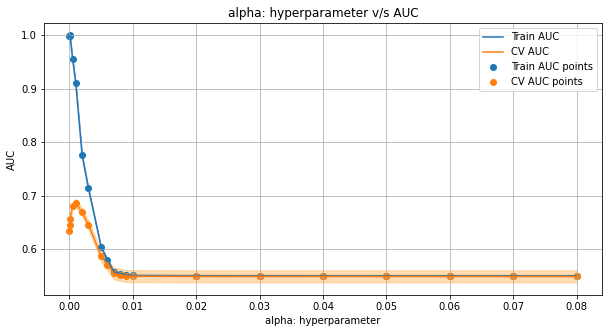

In [72]:
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
plt.figure(figsize=(10,5))
plt.plot(alphas, train_auc, label='Train AUC')
plt.gca().fill_between(alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(alphas, cv_auc, label='CV AUC')
plt.gca().fill_between(alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(alphas, train_auc, label='Train AUC points')
plt.scatter(alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

Testing the model with best hyperparameter alpha



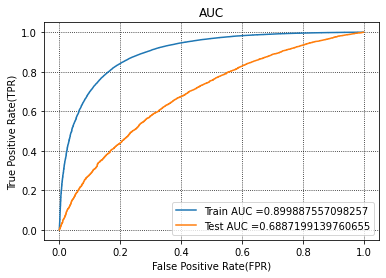

In [76]:
from sklearn.metrics import roc_curve, auc

lor = SGDClassifier(alpha=bestAlpha_1,loss="log")
lor.fit(x_train_onehot_bow, y_train)
y_train_pred=lor.predict_proba(x_train_onehot_bow)[:,1]
y_test_pred=lor.predict_proba(x_test_onehot_bow)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
ax = plt.subplot()
auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)
ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

Confusion Matrix

In [0]:
## confusion matrix of training data
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.6751450371011997 for threshold 0.804
[[10817  2417]
 [12904 61258]]
the maximum value of tpr*(1-fpr) 0.6751450371011997 for threshold 0.804


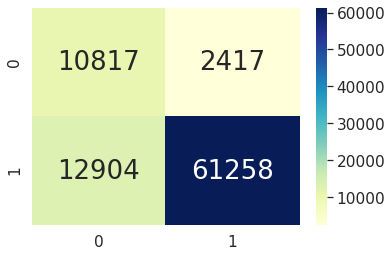

In [78]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))
## https://likegeeks.com/seaborn-heatmap-tutorial/#Sequential-colormap
sns.set(font_scale=1.4)
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.4097435097105294 for threshold 0.853
[[ 2320   988]
 [ 7866 10675]]
the maximum value of tpr*(1-fpr) 0.4097435097105294 for threshold 0.853


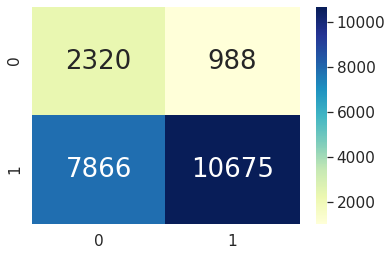

In [79]:
## test confusion matrix

Applying Logistic Regression on TF-IDF and using gridsearchcv to find best alpha

In [86]:
from sklearn.model_selection import GridSearchCV
lor_tfidf = SGDClassifier(loss="log")
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf = GridSearchCV(lor_tfidf, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
clf.fit(x_train_onehot_tfidf,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestAlpha_2=clf.best_params_['alpha']
bestScore_2=clf.best_score_
print("Best alpha: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.1min finished


Best alpha:  1e-05  BEST SCORE:  0.6572839288467784


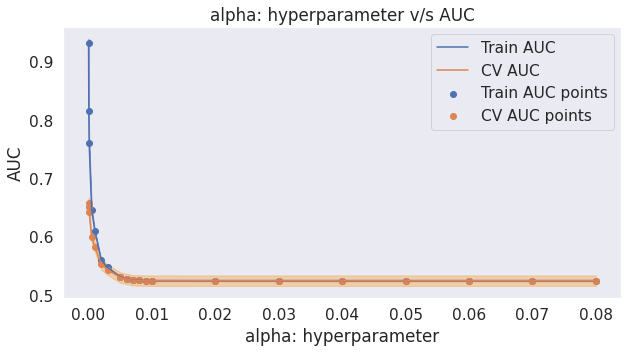

In [88]:
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
plt.figure(figsize=(10,5))
plt.plot(alphas, train_auc, label='Train AUC')
plt.gca().fill_between(alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(alphas, cv_auc, label='CV AUC')
plt.gca().fill_between(alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(alphas, train_auc, label='Train AUC points')
plt.scatter(alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

Testing the model with best hyperparameter alpha


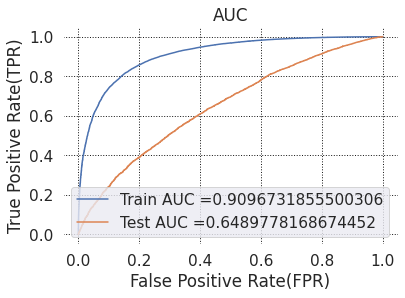

In [95]:
lor_tfidf = SGDClassifier(alpha=bestAlpha_2,loss="log")
lor_tfidf.fit(x_train_onehot_tfidf, y_train)
y_train_pred=lor_tfidf.predict_proba(x_train_onehot_tfidf)[:,1]
y_test_pred=lor_tfidf.predict_proba(x_test_onehot_tfidf)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
ax = plt.subplot()
auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)
ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

Confusion Matrix

In [0]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.7248091564428937 for threshold 0.8
[[11278  1956]
 [11086 63076]]
the maximum value of tpr*(1-fpr) 0.7248091564428937 for threshold 0.8


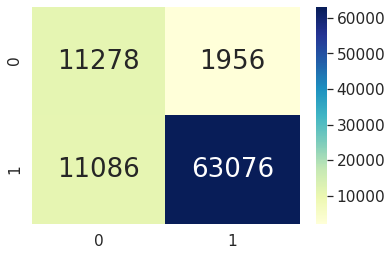

In [91]:
#training confusion matrix
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.34077398780323254 for threshold 0.83
[[ 3290    18]
 [18295   246]]
the maximum value of tpr*(1-fpr) 0.34077398780323254 for threshold 0.83


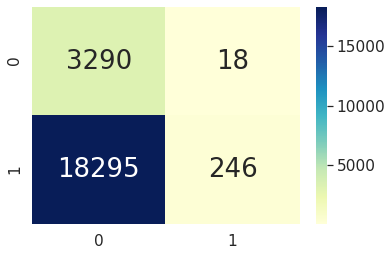

In [92]:
#test Confusion Matrix
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 26}, fmt='g' ,cmap='YlGnBu')

avg w2v

In [93]:
from sklearn.model_selection import GridSearchCV
lor_avgw2v = SGDClassifier(loss="log")
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf = GridSearchCV(lor_avgw2v, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
clf.fit(x_train_onehot_avgw2v,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestAlpha_3=clf.best_params_['alpha']
bestScore_3=clf.best_score_
print("Best alpha: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished


Best alpha:  5e-05  BEST SCORE:  0.6453434480202741


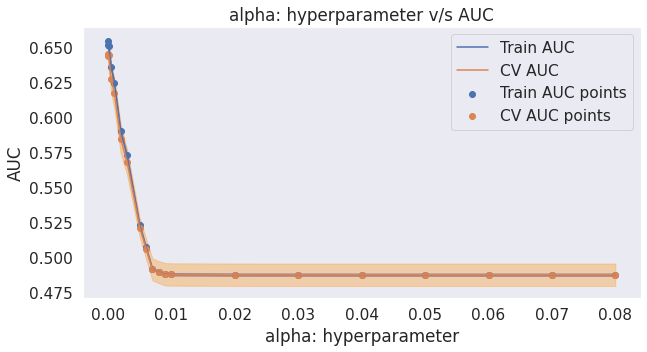

In [94]:
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
plt.figure(figsize=(10,5))
plt.plot(alphas, train_auc, label='Train AUC')
plt.gca().fill_between(alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(alphas, cv_auc, label='CV AUC')
plt.gca().fill_between(alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(alphas, train_auc, label='Train AUC points')
plt.scatter(alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

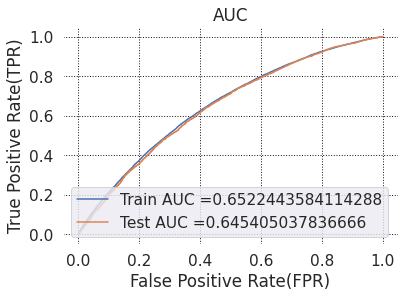

In [100]:
lor_avgw2v = SGDClassifier(alpha=bestAlpha_3,loss="log")
lor_avgw2v.fit(x_train_onehot_avgw2v, y_train)
y_train_pred=lor_avgw2v.predict_proba(x_train_onehot_avgw2v)[:,1]
y_test_pred=lor_avgw2v.predict_proba(x_test_onehot_avgw2v)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
ax = plt.subplot()
auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)
ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

In [0]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.3683491389237674 for threshold 0.825
[[ 7838  5396]
 [28038 46124]]
the maximum value of tpr*(1-fpr) 0.3683491389237674 for threshold 0.825


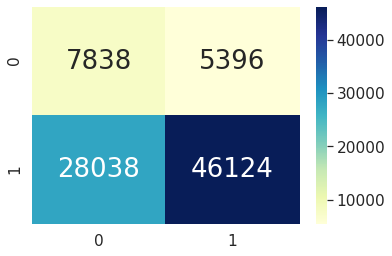

In [98]:
#training confusion matrix
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.35819920843423775 for threshold 0.908
[[ 2953   355]
 [14895  3646]]
the maximum value of tpr*(1-fpr) 0.35819920843423775 for threshold 0.908


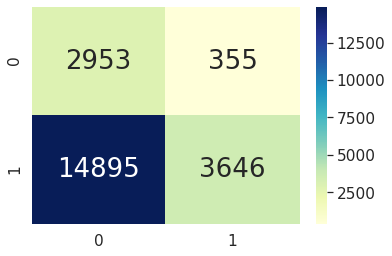

In [99]:
#test Confusion Matrix
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 26}, fmt='g' ,cmap='YlGnBu')

tfidf w2v

In [101]:
from sklearn.model_selection import GridSearchCV
lor_tfidfw2v = SGDClassifier(loss="log")
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf = GridSearchCV(lor_tfidfw2v, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
clf.fit(x_train_onehot_tfidfw2v,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestAlpha_4=clf.best_params_['alpha']
bestScore_4=clf.best_score_
print("Best alpha: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished


Best alpha:  0.0001  BEST SCORE:  0.653933752912448


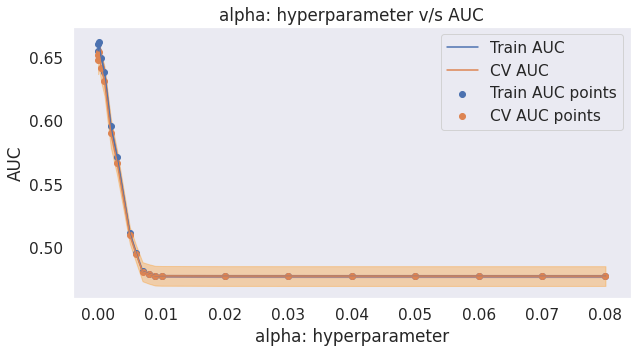

In [102]:
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
plt.figure(figsize=(10,5))
plt.plot(alphas, train_auc, label='Train AUC')
plt.gca().fill_between(alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(alphas, cv_auc, label='CV AUC')
plt.gca().fill_between(alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(alphas, train_auc, label='Train AUC points')
plt.scatter(alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

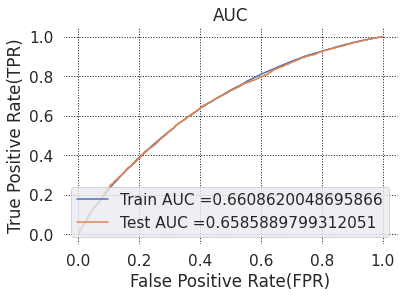

In [104]:
lor_tfidfw2v = SGDClassifier(alpha=bestAlpha_4,loss="log")
lor_tfidfw2v.fit(x_train_onehot_tfidfw2v, y_train)
y_train_pred=lor_tfidfw2v.predict_proba(x_train_onehot_tfidfw2v)[:,1]
y_test_pred=lor_tfidfw2v.predict_proba(x_test_onehot_tfidfw2v)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
ax = plt.subplot()
auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)
ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

In [0]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.38278226236012486 for threshold 0.846
[[ 7916  5318]
 [26703 47459]]
the maximum value of tpr*(1-fpr) 0.38278226236012486 for threshold 0.846


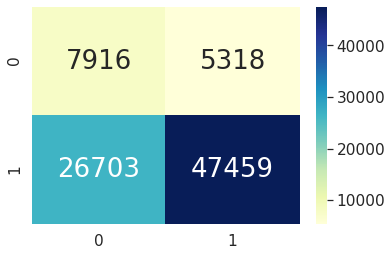

In [106]:
#training confusion matrix
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.3844932016739659 for threshold 0.913
[[ 3010   298]
 [14512  4029]]
the maximum value of tpr*(1-fpr) 0.3844932016739659 for threshold 0.913


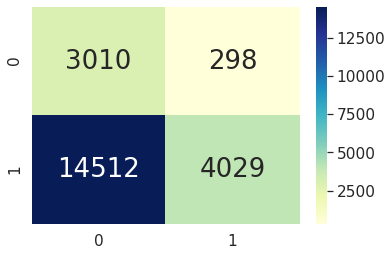

In [107]:
#test Confusion Matrix
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 26}, fmt='g' ,cmap='YlGnBu')

Task5

In [0]:
resource_data=pd.read_csv('/content/drive/My Drive/6_Donors_choose_NB/resources.csv')

In [120]:
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [0]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

In [0]:
x_train = pd.merge(x_train, price_data, on='id', how='left')
x_test = pd.merge(x_test, price_data, on='id', how='left')

In [140]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(x_train['price'].values.reshape(1,-1))
price_train = normalizer.transform(x_train['price'].values.reshape(1,-1))
price_test = normalizer.transform(x_test['price'].values.reshape(1,-1))
print("After vectorizations")
print(price_train.shape)
print(price_test.shape)

After vectorizations
(1, 87396)
(1, 21849)


In [141]:
normalizer = Normalizer()

normalizer.fit(x_train['quantity'].values.reshape(1,-1))
quantity_train = normalizer.transform(x_train['quantity'].values.reshape(1,-1))
quantity_test = normalizer.transform(x_test['quantity'].values.reshape(1,-1))

print("After vectorizations")
print(quantity_train.shape)
print(quantity_test.shape)

After vectorizations
(1, 87396)
(1, 21849)


In [124]:
normalizer = Normalizer()

normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
prev_projects_train = normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(prev_projects_train.shape)
print(prev_projects_test.shape)

After vectorizations
(87396, 1)
(21849, 1)


In [130]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [131]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

neg = []
pos = []
neu = []
compound = []
for a in tqdm(project_data["preprocessed_essays"]) :
  b = analyser.polarity_scores(a)['neg']
  c = analyser.polarity_scores(a)['pos']
  d = analyser.polarity_scores(a)['neu']
  e = analyser.polarity_scores(a)['compound']
  neg.append(b)
  pos.append(c)
  neu.append(d)
  compound.append(e)

project_data["pos"] = pos
project_data["neg"] = neg
project_data["neu"] = neu
project_data["compound"] = compound

100%|██████████| 109245/109245 [12:41<00:00, 143.53it/s]


In [133]:
normalizer = Normalizer()
normalizer.fit(x_train['pos'].values.reshape(1,-1))
essay_sent_pos_train = normalizer.transform(x_train['pos'].values.reshape(1,-1))
essay_sent_pos_test = normalizer.transform(x_test['pos'].values.reshape(1,-1))
print("After vectorizations")
print(essay_sent_pos_train.shape)
print(essay_sent_pos_test.shape)

After vectorizations
(1, 87396)
(1, 21849)


In [134]:
normalizer = Normalizer()
normalizer.fit(x_train['neg'].values.reshape(1,-1))
essay_sent_neg_train = normalizer.transform(x_train['neg'].values.reshape(1,-1))
essay_sent_neg_test = normalizer.transform(x_test['neg'].values.reshape(1,-1))
print("After vectorizations")
print(essay_sent_neg_train.shape)
print(essay_sent_neg_test.shape)

After vectorizations
(1, 87396)
(1, 21849)


In [135]:
normalizer = Normalizer()
normalizer.fit(x_train['neu'].values.reshape(1,-1))
essay_sent_neu_train = normalizer.transform(x_train['neu'].values.reshape(1,-1))
essay_sent_neu_test = normalizer.transform(x_test['neu'].values.reshape(1,-1))
print("After vectorizations")
print(essay_sent_neu_train.shape)
print(essay_sent_neu_test.shape)

After vectorizations
(1, 87396)
(1, 21849)


In [136]:
normalizer = Normalizer()
normalizer.fit(x_train['compound'].values.reshape(1,-1))
essay_sent_comp_train = normalizer.transform(x_train['compound'].values.reshape(1,-1))
essay_sent_comp_test = normalizer.transform(x_test['compound'].values.reshape(1,-1))
print("After vectorizations")
print(essay_sent_comp_train.shape)
print(essay_sent_comp_test.shape)

After vectorizations
(1, 87396)
(1, 21849)


In [0]:
price_train = (x_train['price'].values.reshape(-1,1))
price_test = (x_test['price'].values.reshape(-1,1))
quantity_train =(x_train['quantity'].values.reshape(-1,1))
quantity_test = (x_test['quantity'].values.reshape(-1,1))
prev_projects_train = (x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = (x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
essay_sent_pos_train = (x_train['pos'].values.reshape(-1,1))
essay_sent_pos_test = (x_test['pos'].values.reshape(-1,1))
essay_sent_neg_train = (x_train['neg'].values.reshape(-1,1))
essay_sent_neg_test = (x_test['neg'].values.reshape(-1,1))
essay_sent_neu_train = (x_train['neu'].values.reshape(-1,1))
essay_sent_neu_test = (x_test['neu'].values.reshape(-1,1))
essay_sent_comp_train = (x_train['compound'].values.reshape(-1,1))
essay_sent_comp_test = (x_test['compound'].values.reshape(-1,1))

  <li><strong>school_state</strong> : categorical data</li>
                <li><strong>clean_categories</strong> : categorical data</li>
                <li><strong>clean_subcategories</strong> : categorical data</li>
                <li><strong>project_grade_category</strong> :categorical data</li>
                <li><strong>teacher_prefix</strong> : categorical data</li>
                <li><strong>quantity</strong> : numerical data</li>
                <li><strong>teacher_number_of_previously_posted_projects</strong> : numerical data</li>
                <li><strong>price</strong> : numerical data</li>
                <li><strong>sentiment score's of each of the essay</strong> : numerical data</li>
                <li><strong>number of words in the title</strong> : numerical data</li>
                <li><strong>number of words in the combine essays</strong> : numerical data</li>

In [0]:
x_train_onehot2 = hstack((x_train_onehot,price_train,quantity_train,essay_sent_pos_train,essay_sent_neg_train,essay_sent_neu_train,essay_sent_comp_train))

In [0]:
x_test_onehot2 = hstack((x_test_onehot,price_test,quantity_test,essay_sent_pos_test,essay_sent_neg_test,essay_sent_neu_test,essay_sent_comp_test))

In [145]:
from sklearn.model_selection import GridSearchCV
lor_t2 = SGDClassifier(loss="log")
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf = GridSearchCV(lor_t2, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
clf.fit(x_train_onehot2,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestAlpha_4=clf.best_params_['alpha']
bestScore_4=clf.best_score_
print("Best alpha: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.7min finished


Best alpha:  0.005  BEST SCORE:  0.5192456073563991


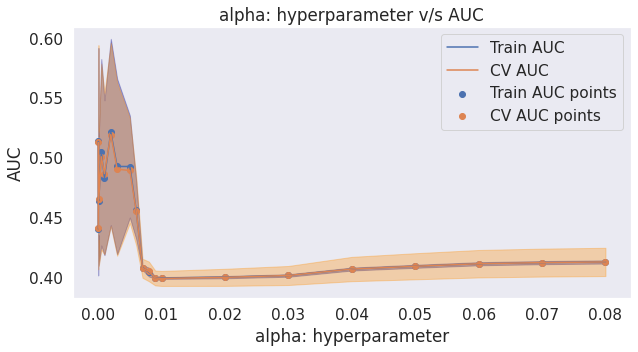

In [146]:
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
plt.figure(figsize=(10,5))
plt.plot(alphas, train_auc, label='Train AUC')
plt.gca().fill_between(alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(alphas, cv_auc, label='CV AUC')
plt.gca().fill_between(alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(alphas, train_auc, label='Train AUC points')
plt.scatter(alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

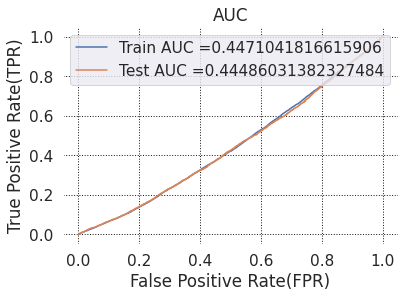

In [147]:
lor_t2 = SGDClassifier(alpha=bestAlpha_4,loss="log")
lor_t2.fit(x_train_onehot2, y_train)
y_train_pred=lor_t2.predict_proba(x_train_onehot2)[:,1]
y_test_pred=lor_t2.predict_proba(x_test_onehot2)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
ax = plt.subplot()
auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)
ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

In [0]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.213948881954738 for threshold 0.948
[[ 5650  7584]
 [36997 37165]]
the maximum value of tpr*(1-fpr) 0.213948881954738 for threshold 0.948


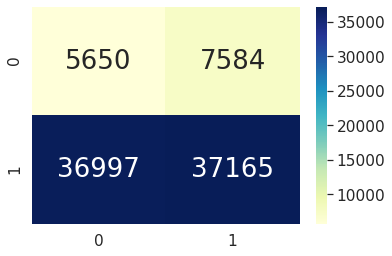

In [149]:
#training confusion matrix
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.21569575176606215 for threshold 0.99
[[ 2831   477]
 [16791  1750]]
the maximum value of tpr*(1-fpr) 0.21569575176606215 for threshold 0.99


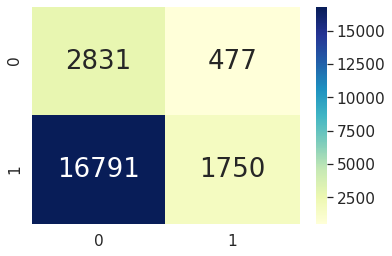

In [150]:
#test Confusion Matrix
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 26}, fmt='g' ,cmap='YlGnBu')

In [155]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Alpha:Hyper Parameter", "AUC"]
x.add_row(["BOW", "Logistic Regression", 0.001, 0.68])
x.add_row(["TFIDF", "Logistic Regression", 0.00001, 0.65])
x.add_row(["AVG W2V", "Logistic Regression", 0.00005, 0.64])
x.add_row(["TFIDF W2V", "Logistic Regression", 0.0001, 0.65])
x.add_row(["numerical features", "Logistic Regression", 0.005, 0.51])
print(x)

+--------------------+---------------------+-----------------------+------+
|     Vectorizer     |        Model        | Alpha:Hyper Parameter | AUC  |
+--------------------+---------------------+-----------------------+------+
|        BOW         | Logistic Regression |         0.001         | 0.68 |
|       TFIDF        | Logistic Regression |         1e-05         | 0.65 |
|      AVG W2V       | Logistic Regression |         5e-05         | 0.64 |
|     TFIDF W2V      | Logistic Regression |         0.0001        | 0.65 |
| numerical features | Logistic Regression |         0.005         | 0.51 |
+--------------------+---------------------+-----------------------+------+
